In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.append("../src/")

In [3]:
#export
from nb_05 import *
torch.set_num_threads(2)

## ConvNet

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [6]:
nfs = [8,16,32,64,64]

In [7]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [8]:
%time run.fit(2, learn)

train: [1.96413125, tensor(0.3240, device='cuda:0')]
valid: [0.66959501953125, tensor(0.7920, device='cuda:0')]
train: [0.37866703125, tensor(0.8797, device='cuda:0')]
valid: [0.19259788818359375, tensor(0.9398, device='cuda:0')]
CPU times: user 4.89 s, sys: 1.32 s, total: 6.21 s
Wall time: 6.23 s


## Batchnorm

In [13]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [14]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [15]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.21780138671875, tensor(0.9324, device='cuda:0')]
valid: [0.09301122436523437, tensor(0.9727, device='cuda:0')]


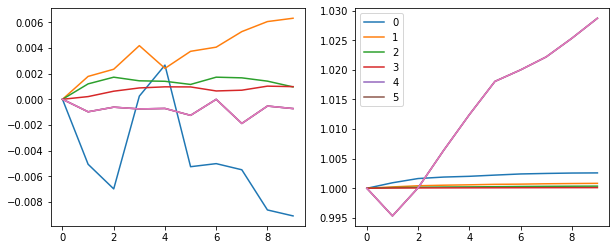

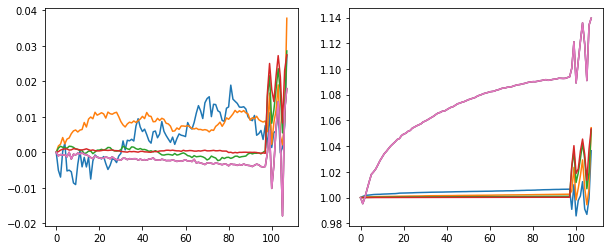

In [16]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [17]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [18]:
%time run.fit(3, learn)

train: [0.22216578125, tensor(0.9298, device='cuda:0')]
valid: [0.0883144287109375, tensor(0.9754, device='cuda:0')]
train: [0.068196806640625, tensor(0.9791, device='cuda:0')]
valid: [0.09750598754882812, tensor(0.9706, device='cuda:0')]
train: [0.047755361328125, tensor(0.9846, device='cuda:0')]
valid: [0.064708642578125, tensor(0.9805, device='cuda:0')]
CPU times: user 5.22 s, sys: 862 ms, total: 6.08 s
Wall time: 6.07 s


### With scheduler

In [19]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [20]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [21]:
run.fit(8, learn)

train: [0.25001255859375, tensor(0.9250, device='cuda:0')]
valid: [0.16365418701171874, tensor(0.9469, device='cuda:0')]
train: [0.08068314453125, tensor(0.9745, device='cuda:0')]
valid: [0.0768710693359375, tensor(0.9772, device='cuda:0')]
train: [0.05474818359375, tensor(0.9827, device='cuda:0')]
valid: [0.05814957275390625, tensor(0.9827, device='cuda:0')]
train: [0.0315816064453125, tensor(0.9899, device='cuda:0')]
valid: [0.06086412353515625, tensor(0.9820, device='cuda:0')]
train: [0.01890156494140625, tensor(0.9944, device='cuda:0')]
valid: [0.04798454284667969, tensor(0.9869, device='cuda:0')]
train: [0.010594322509765625, tensor(0.9974, device='cuda:0')]
valid: [0.04628697204589844, tensor(0.9868, device='cuda:0')]
train: [0.00608360107421875, tensor(0.9988, device='cuda:0')]
valid: [0.039093661499023435, tensor(0.9892, device='cuda:0')]
train: [0.003887418212890625, tensor(0.9996, device='cuda:0')]
valid: [0.039679794311523436, tensor(0.9888, device='cuda:0')]


In [22]:
%%bash
python3 "../src/notebook2script.py" 06_batchnorm.ipynb

Converted 06_batchnorm.ipynb to ../src/nb_06.py
